In [1]:
import rasterio as rio
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.enums import Resampling
import glob
from shapely.geometry import box
from shapely.geometry import mapping
import geopandas as gpd
from shapely.geometry import shape,box
import fiona
from geocube.api.core import make_geocube
import os
import shutil
import numpy as np

In [2]:
import time

# Record the start time
start_time = time.time()

# Your code here - this is where you would place the code you want to time



In [3]:
def raster_to_dissolved_shapefile(WD_raster_file):
    """
    Convert a raster to a dissolved shapefile.
    
    Args:
    - raster_file: Path to the raster file.
    """
    # Open the raster file
    with rio.open(WD_raster_file) as src:
        # Read raster data and transform to polygon shapes
        raster_data = src.read(1)  # Assuming it's a single band raster
        results = list(shapes(raster_data, mask=None, transform=src.transform))

        # Get nodata value from raster metadata
        nodata_value = src.nodatavals[0]  # Assuming it's a single band raster

    # Convert polygon shapes to GeoDataFrame
    geoms = []
    for geom, value in results:
        if value != nodata_value:  # Exclude nodata values
            geom = shape(geom)
            geoms.append(geom)

    gdf = gpd.GeoDataFrame(geometry=geoms)

    # Dissolve polygons
    dissolved = gdf.dissolve()

    # Save dissolved shapefile
    dissolved.to_file(os.path.join(os.getcwd(),'Shapefiles','Dissolved_Waterdepth.shp'))

    print("Dissolved shapefile saved successfully.")

    return dissolved

   

In [4]:
def clip_geodatabase(gdb_file, clipping_shapefile):
    """
    Clips a geodatabase file to the extent of a given shapefile and saves the result to a new shapefile.

    Parameters:
    - gdb_file (str): Path to the geodatabase file to be clipped.
    - clipping_shapefile (str): Path to the shapefile used to define the clipping extent.

    Returns:
    - None
    """
    # Read the geometry of the clipping shapefile
    #clipping_gdf = gpd.read_file(clipping_shapefile)

    clipping_gdf=clipping_shapefile

    # Extract bounding box coordinates from the dissolved shapefile's geometry
    xmin, ymin, xmax, ymax = clipping_gdf.geometry.total_bounds
    clipping_box = (xmin, ymin, xmax, ymax)

    # Perform the clipping operation
    clipped_gdf = gpd.read_file(gdb_file, bbox=clipping_box)

    # Save the clipped GeoDataFrame to a shapefile
    clipped_gdf.to_file(os.path.join(os.getcwd(),'Shapefiles','Clipped_Beam.shp'))
    print('Beam dataset clipped successfully' )
    return clipped_gdf




In [5]:
def create_raster_from_column(gdf, raster_col, pixel_size, output_filename):
    """
    Create a raster from a column in a GeoDataFrame using geocube.

    Parameters:
    - gdf (geopandas.GeoDataFrame): Input GeoDataFrame.
    - column (str): Name of the column to create a raster from.
    - pixel_size (float): Size of each pixel in meters.
    - output_filename (str): Output filename for the raster.

    Returns:
    - None
    """

    # Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
    gdf[raster_col] *= 25
    
    out_grid= make_geocube(vector_data=gdf, measurements=[raster_col], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid[raster_col].rio.to_raster(output_filename)


In [6]:
def get_raster_files(folder_path):
    """
    Get a list of all raster files in a folder.

    Parameters:
    - folder_path (str): Path to the folder containing raster files.

    Returns:
    - raster_files (list): List of paths to raster files.
    """
    raster_files = []
    for file in os.listdir(folder_path):
        if file.endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png')):
            raster_files.append(os.path.join(folder_path, file))
    return raster_files


In [7]:
def clip_raster_with_raster(input_raster_path, clipping_raster_path, output_clipped_raster_path):
    # Open the input raster (the raster to be clipped)
    input_raster = rio.open(input_raster_path)

    # Open the clipping raster (the raster defining the extent of the clip)
    clipping_raster = rio.open(clipping_raster_path)

    try:
        # Read the extent of the clipping raster
        clipping_extent = box(*clipping_raster.bounds)

        # Create a GeoJSON-like dictionary representing the clipping extent
        clipping_extent_geojson = mapping(clipping_extent)

        # Perform the clip operation
        clipped_data, clipped_transform = mask(input_raster, [clipping_extent_geojson], crop=True)

        # Update the metadata
        clipped_meta = input_raster.meta
        clipped_meta.update({'driver': 'GTiff',
                             'height': clipped_data.shape[1],
                             'width': clipped_data.shape[2],
                             'transform': clipped_transform})

        # Save the clipped raster to a new file
        with rio.open(output_clipped_raster_path, 'w', **clipped_meta) as dst:
            dst.write(clipped_data)

        print(f"Clipping {os.path.basename(raster)} completed successfully!")

    finally:
        # Close the raster files
        input_raster.close()
        clipping_raster.close()

        # delete the raster which we do not need 
        os.remove(input_raster_path)

In [8]:
# Change the current directory to the working directory
os.chdir(os.getcwd())

# Input data

WD_raster_file = "sahrbach_water_depth_5m_3035.tif" # path to waterdepth raster file


BEAM_file = r"D:\BEAM\Beam_dataset\beam_de2021.gdb"  # path to Beam dataset


# Output data
#WD_dissolved_shp = os.path.join(os.getcwd(),'Shapefiles','Dissolved_Waterdepth.shp')
#Clipped_Beam_shp = os.path.join(os.getcwd(),'Shapefiles','Clipped_Beam.shp')

WD_dissolved=raster_to_dissolved_shapefile(WD_raster_file)
Clipped_beam=clip_geodatabase(BEAM_file, WD_dissolved)

Dissolved shapefile saved successfully.
Beam dataset clipped successfully


C:\Users\Omar.Seleem\AppData\Local\Temp\ipykernel_12736\2939528128.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_gdf.to_file(os.path.join(os.getcwd(),'Shapefiles','Clipped_Beam.shp'))


## Create rasters from BEAM columns


In [9]:
# Column names that will be converted to raster
raster_colums=['building', 'household', 'vehicles',
       'nav_agriculture', 'nav_industry', 'nav_service', 'livestock',
       'sit_agriculture', 'sit_industry', 'sit_service']


directory_name = 'Beam_rasters'
directory_path = os.path.join(os.getcwd(), directory_name)

# Check if the directory exists
if os.path.exists(directory_path):
    try:
        # Attempt to remove the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_name}' and its contents removed successfully.")
    except Exception as e:
        print(f"An error occurred while removing the directory: {e}")

try:
    # Create the directory
    os.mkdir(directory_path)
    print(f"Directory '{directory_name}' created successfully.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")


# Make a raster from each landuse type in the Beam dataset and save the rasters in a folder called Beam_rasters
for raster_col in raster_colums:
    create_raster_from_column(Clipped_beam, raster_col, 5, os.path.join(os.getcwd(),'Beam_rasters',str(raster_col)+'.tif'))


Directory 'Beam_rasters' created successfully.


Note: 
The generated rasters for each land use are derived from the intersecting areas between the dissolved water depth shapefile and the BEAM dataset. However, certain features extend beyond the boundaries of the water depth data. Therefore, it becomes necessary to clip the rasters to match the extent of the water depth raster.


## Clip the rasters with the water depth raster

In [10]:
# get a list with all the raster names 
folder_path = os.path.join(os.getcwd(),'Beam_rasters')
Beam_raster_files = get_raster_files(folder_path)
Beam_raster_files

['D:\\BEAM\\Omar_tool\\Beam_rasters\\building.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\household.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\livestock.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\nav_agriculture.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\nav_industry.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\nav_service.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\sit_agriculture.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\sit_industry.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\sit_service.tif',
 'D:\\BEAM\\Omar_tool\\Beam_rasters\\vehicles.tif']

In [11]:
Beam_raster_files[0][-12:-4]

'building'

In [12]:
directory_name = 'Beam_rasters_clipped'
directory_path = os.path.join(os.getcwd(), directory_name)

# Check if the directory exists
if os.path.exists(directory_path):
    try:
        # Attempt to remove the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_name}' and its contents removed successfully.")
    except Exception as e:
        print(f"An error occurred while removing the directory: {e}")

try:
    # Create the directory
    os.mkdir(directory_path)
    print(f"Directory '{directory_name}' created successfully.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")



for raster in Beam_raster_files:
    input_raster_path = raster # path to Beam rasters 
    clipping_raster_path = WD_raster_file # Path to water depth raster 
    output_clipped_raster_path = os.path.join(os.getcwd(),'Beam_rasters_clipped',os.path.basename(raster))
    clip_raster_with_raster(input_raster_path, clipping_raster_path, output_clipped_raster_path)

# remove the directory which we do not need
os.rmdir(os.path.join(os.getcwd(),'Beam_rasters'))

Directory 'Beam_rasters_clipped' and its contents removed successfully.
Directory 'Beam_rasters_clipped' created successfully.
Clipping building.tif completed successfully!
Clipping household.tif completed successfully!
Clipping livestock.tif completed successfully!
Clipping nav_agriculture.tif completed successfully!
Clipping nav_industry.tif completed successfully!
Clipping nav_service.tif completed successfully!
Clipping sit_agriculture.tif completed successfully!
Clipping sit_industry.tif completed successfully!
Clipping sit_service.tif completed successfully!
Clipping vehicles.tif completed successfully!


## Calcualte damage

In [13]:
directory_name = 'damage_rasters'
directory_path = os.path.join(os.getcwd(), directory_name)

# Check if the directory exists
if os.path.exists(directory_path):
    try:
        # Attempt to remove the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_name}' and its contents removed successfully.")
    except Exception as e:
        print(f"An error occurred while removing the directory: {e}")

try:
    # Create the directory
    os.mkdir(directory_path)
    print(f"Directory '{directory_name}' created successfully.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")

Directory 'damage_rasters' and its contents removed successfully.
Directory 'damage_rasters' created successfully.


In [14]:
def calculate_damage_building(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A and raster B files
    with rio.open(raster_a_file) as src_a:
        raster_a = src_a.read(1, out_shape=(src_a.height, src_a.width))
        profile_a = src_a.profile  # Get metadata

    with rio.open(raster_b_file) as src_b:
        raster_b = src_b.read(1, out_shape=(src_a.height, src_a.width))  # Match shape of raster A

    # Perform calculations for raster C
    raster_c = np.where(raster_a < 800, raster_b * ((raster_a / 100) * 0.125), raster_b * 1)

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"Building damage raster is saved successfully to: {output_raster_file}")
    

# Buildings damage
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','building.tif') # Buildings raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','building_damage.tif') # Building damage raster as a function of water depth and Building value from BEAM

calculate_damage_building(raster_a_file, raster_b_file, output_raster_file)

Building damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\building_damage.tif


In [15]:
def calculate_damage_household(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)

        # Get metadata of raster A
        transform = src_a.transform
        height = src_a.height
        width = src_a.width
        crs = src_a.crs

    # Open raster B and align its properties to raster A
    with rio.open(raster_b_file) as src_b:
        # Align raster B to match raster A's properties
        raster_b = src_b.read(
            out_shape=(src_b.count, height, width),
            resampling=rio.enums.Resampling.bilinear
        )

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 100)
    condition2 = (raster_a >= 100) & (raster_a < 700)
    condition3 = (raster_a >= 700)

    # Update raster C based on conditions
    raster_c[condition1] = raster_b[0][condition1] * ((raster_a[condition1] / 100) * 0.4)
    raster_c[condition2] = raster_b[0][condition2] * (((raster_a[condition2] / 100) * 0.1) + 0.3)
    raster_c[condition3] = raster_b[0][condition3] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"Household damage raster is saved successfully to: {output_raster_file}")

# hosuhold damage
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','household.tif') # Household raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','household_damage.tif') # Household damage raster as a function of water depth and Building value from BEAM


calculate_damage_household(raster_a_file, raster_b_file, output_raster_file)


Household damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\household_damage.tif


In [16]:
def calculate_damage_vehicles(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile
        # Read raster A
        raster_a = src_a.read(1)
        # Get metadata of raster A
        transform = src_a.transform
        height = src_a.height
        width = src_a.width
        crs = src_a.crs

    # Open raster B to get its metadata and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height, width),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 25)
    condition2 = (raster_a >= 25) & (raster_a < 150)
    condition3 = (raster_a >= 150)

    # Update raster C based on conditions
    raster_c[condition1] = 0
    raster_c[condition2] = data_b[0][condition2] * (((raster_a[condition2] / 100) * 0.24) - 0.06)
    raster_c[condition3] = data_b[0][condition3] * 0.3

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"Vehicles damage raster is saved successfully to: {output_raster_file}")


# vehicles damage
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','vehicles.tif') # vehicles raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','vehicles_damage.tif') # vehicles damage raster as a function of water depth and Building value from BEAM


calculate_damage_vehicles(raster_a_file, raster_b_file, output_raster_file)

Vehicles damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\vehicles_damage.tif


In [17]:
def calculate_damage_nav_agriculture(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 1000)
    condition2 = (raster_a >= 1000)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100) * 0.1)
    raster_c[condition2] = data_b[0][condition2] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"nav_agriculture_damage raster is saved successfully to: {output_raster_file}")


# nav_agriculture damage
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','nav_agriculture.tif') # nav_agriculture raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','nav_agriculture_damage.tif') # nav_agriculture_damage raster as a function of water depth and Building value from BEAM


calculate_damage_nav_agriculture(raster_a_file, raster_b_file, output_raster_file)

nav_agriculture_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\nav_agriculture_damage.tif


In [18]:
def calculate_damage_nav_industry(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 800)
    condition2 = (raster_a >= 800)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100) * 0.125)
    raster_c[condition2] = data_b[0][condition2] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"nav_industry_damage raster is saved successfully to: {output_raster_file}")

# nav_industry_damage damage
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','nav_industry.tif') # nav_industry raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','nav_industry_damage.tif') # nav_industry_damage raster as a function of water depth and Building value from BEAM


calculate_damage_nav_industry(raster_a_file, raster_b_file, output_raster_file)

nav_industry_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\nav_industry_damage.tif


In [19]:
def calculate_damage_nav_service(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 800)
    condition2 = (raster_a >= 800)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100) * 0.125)
    raster_c[condition2] = data_b[0][condition2] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"nav_service_damage raster is saved successfully to: {output_raster_file}")

# nav_service_damage 
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','nav_service.tif') # nav_service raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','nav_service_damage.tif') # nav_service_damage raster as a function of water depth and Building value from BEAM


calculate_damage_nav_service(raster_a_file, raster_b_file, output_raster_file)

nav_service_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\nav_service_damage.tif


In [20]:
def calculate_damage_sit_agriculture(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 100)
    condition2 = (raster_a >= 100)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100))
    raster_c[condition2] = data_b[0][condition2] * 1
    #raster_c[condition2] = data_b[0][condition2] * raster_a[condition2]

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"sit_agriculture_damage raster is saved successfully to: {output_raster_file}")

# sit_agriculture_damage 
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','sit_agriculture.tif') # sit_agriculture raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','sit_agriculture_damage.tif') # sit_agriculture_damage raster as a function of water depth and Building value from BEAM

calculate_damage_sit_agriculture(raster_a_file, raster_b_file, output_raster_file)

sit_agriculture_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\sit_agriculture_damage.tif


In [21]:
def calculate_damage_livestock(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    condition1 = (raster_a < 100)
    condition2 = (raster_a >= 100)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100))
    raster_c[condition2] = data_b[0][condition2] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"livestock_damage raster is saved successfully to: {output_raster_file}")

# livestock_damage 
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','livestock.tif') # livestock raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','livestock_damage.tif') # livestock_damage raster as a function of water depth and Building value from BEAM


calculate_damage_livestock(raster_a_file, raster_b_file, output_raster_file)

livestock_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\livestock_damage.tif


In [22]:
def calculate_damage_sit_industry(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 200)
    condition2 = (raster_a >= 200) & (raster_a < 400)
    condition3 = (raster_a >= 400)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.2)
    raster_c[condition2] = data_b[0][condition2] * (((raster_a[condition2] / 100)*0.05)+0.3)
    raster_c[condition3] = data_b[0][condition3] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"sit_industry_damage raster is saved successfully to: {output_raster_file}")

# sit_industry_damage 
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','sit_industry.tif') # sit_industry raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','sit_industry_damage.tif') # sit_industry_damage raster as a function of water depth and Building value from BEAM


calculate_damage_sit_industry(raster_a_file, raster_b_file, output_raster_file)

sit_industry_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\sit_industry_damage.tif


In [23]:
def calculate_damage_sit_service(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 200)
    condition2 = (raster_a >= 200) & (raster_a < 600)
    condition3 = (raster_a >= 600)

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.4)
    raster_c[condition2] = data_b[0][condition2] * (((raster_a[condition2] / 100)*0.05)+0.7)
    raster_c[condition3] = data_b[0][condition3] * 1

    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"sit_service_damage raster is saved successfully to: {output_raster_file}")
    
# sit_industry_damage 
raster_a_file = WD_raster_file # Water depth raster
raster_b_file = os.path.join(os.getcwd(),'Beam_rasters_clipped','sit_service.tif') # sit_service raster
output_raster_file = os.path.join(os.getcwd(),'damage_rasters','sit_service_damage.tif') # sit_service_damage raster as a function of water depth and Building value from BEAM


calculate_damage_sit_service(raster_a_file, raster_b_file, output_raster_file)

sit_service_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\sit_service_damage.tif


### Damage from fix values

In [24]:
Clipped_beam.columns

Index(['esri_id', 'gis_area_sqm', 'nuts0', 'nuts2', 'nuts_label', 'ln_value',
       'label_ln', 'popdensity', 'building', 'household', 'vehicles',
       'nav_agriculture', 'nav_industry', 'nav_service', 'livestock',
       'sit_agriculture', 'sit_industry', 'sit_service', 'fix_value',
       'total_sqm', 'total_euro', 'geometry'],
      dtype='object')

In [25]:
Clipped_beam.head()

,esri_id,gis_area_sqm,nuts0,nuts2,nuts_label,ln_value,label_ln,popdensity,building,household,...,nav_industry,nav_service,livestock,sit_agriculture,sit_industry,sit_service,fix_value,total_sqm,total_euro,geometry
0,5572020,1558.700670,DE,A2,Köln,12223,regional roads (OSM),0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,75.0,76.385840,119062.660221,"MULTIPOLYGON (((4101222.337 3050921.958, 41012..."
1,5572022,3378.460456,DE,A2,Köln,12223,regional roads (OSM),0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,75.0,76.385840,258066.540397,"MULTIPOLYGON (((4102516.271 3051351.321, 41025..."
2,5572033,9615.667802,DE,A2,Köln,12223,regional roads (OSM),0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,75.0,76.385840,734500.863699,"MULTIPOLYGON (((4101763.535 3052057.350, 41017..."
3,5604270,7.537877,DE,A2,Köln,23101,pastures steep terrain,0.0,0.0,0.0,...,0.0,0.0,2.992135,0.264515,0.0,0.0,0.4,1.059295,7.984840,"MULTIPOLYGON (((4101251.941 3050793.942, 41012..."
4,5604275,86.893876,DE,A2,Köln,23101,pastures steep terrain,0.0,0.0,0.0,...,0.0,0.0,2.992135,0.264515,0.0,0.0,0.4,1.059295,92.046291,"MULTIPOLYGON (((4101216.201 3050925.686, 41012..."


In [26]:
directory_name = 'Fixed_values_rasters'
directory_path = os.path.join(os.getcwd(), directory_name)

# Check if the directory exists
if os.path.exists(directory_path):
    try:
        # Attempt to remove the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_name}' and its contents removed successfully.")
    except Exception as e:
        print(f"An error occurred while removing the directory: {e}")

try:
    # Create the directory
    os.mkdir(directory_path)
    print(f"Directory '{directory_name}' created successfully.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")

Directory 'Fixed_values_rasters' created successfully.


In [27]:
# Agriculture 

# Select features where ln_value is between 21101-22300 or between 24100-24400
Agriculture_features = Clipped_beam[
    ((Clipped_beam['ln_value'] >= 21101) & (Clipped_beam['ln_value'] <= 22300)) |
    ((Clipped_beam['ln_value'] >= 24100) & (Clipped_beam['ln_value'] <= 24400))
]

 # Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
Agriculture_features['fix_value'] *= 25

if not Agriculture_features.empty:
       
    out_grid= make_geocube(vector_data=Agriculture_features, measurements=['fix_value'], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid['fix_value'].rio.to_raster(os.path.join(os.getcwd(), 'Fixed_values_rasters','Fix_agriculture.tif'))
else:
    print('There is no agriculture features in this area')


There is no agriculture features in this area


In [28]:
# Grassland 
# Select features where ln_value is between 21101-22300 or between 24100-24400
Grassland_features = Clipped_beam[
    ((Clipped_beam['ln_value'] >= 23101) & (Clipped_beam['ln_value'] <= 23103)) |
    ((Clipped_beam['ln_value'] == 32100))
]

# Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
Grassland_features['fix_value'] *= 25

if not Grassland_features.empty:

        
    out_grid= make_geocube(vector_data=Grassland_features, measurements=['fix_value'], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid['fix_value'].rio.to_raster(os.path.join(os.getcwd(), 'Fixed_values_rasters','Fix_grassland.tif'))
else:
    print('There is no Grassland features in this area')

C:\Users\Omar.Seleem\AppData\Local\anaconda3\envs\damage_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
# Forest 
# Select features where ln_value is between 21101-22300 or between 24100-24400
Forest_features = Clipped_beam[
    ((Clipped_beam['ln_value'] >= 31101) & (Clipped_beam['ln_value'] <= 31303))
]

# Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
Forest_features['fix_value'] *= 25

if not Forest_features.empty:

        
    out_grid= make_geocube(vector_data=Forest_features, measurements=['fix_value'], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid['fix_value'].rio.to_raster(os.path.join(os.getcwd(), 'Fixed_values_rasters','Fix_forest.tif'))

else:
    print('There is no forest features in this area')
    
Forest_features.head()
 

C:\Users\Omar.Seleem\AppData\Local\anaconda3\envs\damage_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,esri_id,gis_area_sqm,nuts0,nuts2,nuts_label,ln_value,label_ln,popdensity,building,household,...,nav_industry,nav_service,livestock,sit_agriculture,sit_industry,sit_service,fix_value,total_sqm,total_euro,geometry
15,5640621,24.692243,DE,A2,Köln,31101,broad-leaved forest steep terrain,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.2,29.630691,"MULTIPOLYGON (((4101217.515 3050931.950, 41012..."
16,5640631,351.339635,DE,A2,Köln,31101,broad-leaved forest steep terrain,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.2,421.607562,"MULTIPOLYGON (((4101385.818 3051085.011, 41013..."
17,5640633,7.708283,DE,A2,Köln,31101,broad-leaved forest steep terrain,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.2,9.249940,"MULTIPOLYGON (((4101432.035 3051211.090, 41014..."
18,5640636,51.818025,DE,A2,Köln,31101,broad-leaved forest steep terrain,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.2,62.181630,"MULTIPOLYGON (((4101431.527 3051218.631, 41014..."
19,5640652,243344.670333,DE,A2,Köln,31101,broad-leaved forest steep terrain,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.2,292013.604400,"MULTIPOLYGON (((4101888.793 3051518.871, 41019..."


In [30]:
# Road 
# Select features where ln_value is between 21101-22300 or between 24100-24400

Road_features = Clipped_beam[((Clipped_beam['ln_value'] >= 12200) & (Clipped_beam['ln_value'] <= 12229))]

# Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
Road_features['fix_value'] *= 25

if not Road_features.empty:

        
    out_grid= make_geocube(vector_data=Road_features, measurements=['fix_value'], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid['fix_value'].rio.to_raster(os.path.join(os.getcwd(), 'Fixed_values_rasters','Fix_road.tif'))

else:
    print('There is no road features in this area')
Road_features.head()
 

C:\Users\Omar.Seleem\AppData\Local\anaconda3\envs\damage_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,esri_id,gis_area_sqm,nuts0,nuts2,nuts_label,ln_value,label_ln,popdensity,building,household,...,nav_industry,nav_service,livestock,sit_agriculture,sit_industry,sit_service,fix_value,total_sqm,total_euro,geometry
0,5572020,1558.700670,DE,A2,Köln,12223,regional roads (OSM),0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1875.0,76.385840,119062.660221,"MULTIPOLYGON (((4101222.337 3050921.958, 41012..."
1,5572022,3378.460456,DE,A2,Köln,12223,regional roads (OSM),0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1875.0,76.385840,258066.540397,"MULTIPOLYGON (((4102516.271 3051351.321, 41025..."
2,5572033,9615.667802,DE,A2,Köln,12223,regional roads (OSM),0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1875.0,76.385840,734500.863699,"MULTIPOLYGON (((4101763.535 3052057.350, 41017..."
147,6307333,97.556379,DE,B1,Koblenz,12222,regional roads bridges (OSM),0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,32375.0,1296.474236,126479.332472,"MULTIPOLYGON (((4106321.077 3048638.191, 41063..."
148,6307334,129.572102,DE,B1,Koblenz,12222,regional roads bridges (OSM),0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,32375.0,1296.474236,167986.891621,"MULTIPOLYGON (((4103374.621 3048754.278, 41033..."


In [31]:
# Rail 
# Select features where ln_value is between 21101-22300 or between 24100-24400
Rail_features = Clipped_beam[
    ((Clipped_beam['ln_value'] >= 12230) & (Clipped_beam['ln_value'] <= 12239))
]


# Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
Rail_features['fix_value'] *= 25

if not Rail_features.empty:

        
    out_grid= make_geocube(vector_data=Rail_features, measurements=['fix_value'], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid['fix_value'].rio.to_raster(os.path.join(os.getcwd(), 'Fixed_values_rasters','Fix_rail.tif'))
    
else:
    print('There is no rail features in this area')    
Rail_features.head()
 

There is no rail features in this area


,esri_id,gis_area_sqm,nuts0,nuts2,nuts_label,ln_value,label_ln,popdensity,building,household,...,nav_industry,nav_service,livestock,sit_agriculture,sit_industry,sit_service,fix_value,total_sqm,total_euro,geometry


In [32]:
# sports 
# Select features where ln_value is between 21101-22300 or between 24100-24400
Sport_features = Clipped_beam[
    ((Clipped_beam['ln_value'] >= 14100) & (Clipped_beam['ln_value'] <= 14200))
]

# Multiply the values in the column by 25 becasue the Beam dataset is calcualted EUR/m2 and the raster cell is 25 m2 (5 x 5 m)
Sport_features['fix_value'] *= 25

if not Sport_features.empty:

        
    out_grid= make_geocube(vector_data=Sport_features, measurements=['fix_value'], resolution=(-5, 5)) #for most crs negative comes first in resolution
    out_grid['fix_value'].rio.to_raster(os.path.join(os.getcwd(), 'Fixed_values_rasters','Fix_sport.tif'))

else:
    print('There is no rail features in this area') 
    
    
Sport_features.head()
 

C:\Users\Omar.Seleem\AppData\Local\anaconda3\envs\damage_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,esri_id,gis_area_sqm,nuts0,nuts2,nuts_label,ln_value,label_ln,popdensity,building,household,...,nav_industry,nav_service,livestock,sit_agriculture,sit_industry,sit_service,fix_value,total_sqm,total_euro,geometry
222,6327551,69.629936,DE,B1,Koblenz,14200,sport and leisure facilities,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.5,2.5,174.074839,"MULTIPOLYGON (((4104703.595 3048803.652, 41046..."
223,6327556,58030.110123,DE,B1,Koblenz,14200,sport and leisure facilities,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.5,2.5,145075.275307,"MULTIPOLYGON (((4104713.022 3048698.717, 41047..."
224,6327557,669.074498,DE,B1,Koblenz,14200,sport and leisure facilities,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.5,2.5,1672.686245,"MULTIPOLYGON (((4102055.761 3049457.701, 41020..."
225,6327558,52.012745,DE,B1,Koblenz,14200,sport and leisure facilities,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.5,2.5,130.031862,"MULTIPOLYGON (((4102302.776 3049511.255, 41023..."
226,6327559,316.101551,DE,B1,Koblenz,14200,sport and leisure facilities,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.5,2.5,790.253878,"MULTIPOLYGON (((4101972.559 3049548.935, 41019..."


## Clip fix values rasters to the water depth raster

In [33]:
# get a list with all the raster names 
folder_path = os.path.join(os.getcwd(),'Fixed_values_rasters')
Fix_raster_files = get_raster_files(folder_path)
Fix_raster_files

['D:\\BEAM\\Omar_tool\\Fixed_values_rasters\\Fix_forest.tif',
 'D:\\BEAM\\Omar_tool\\Fixed_values_rasters\\Fix_grassland.tif',
 'D:\\BEAM\\Omar_tool\\Fixed_values_rasters\\Fix_road.tif',
 'D:\\BEAM\\Omar_tool\\Fixed_values_rasters\\Fix_sport.tif']

In [34]:
Fix_raster_files[0][-14:-4]

'Fix_forest'

In [35]:
directory_name = 'Fixed_values_rasters_clipped'
directory_path = os.path.join(os.getcwd(), directory_name)

In [36]:
# Check if the directory exists
if os.path.exists(directory_path):
    try:
        # Attempt to remove the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_name}' and its contents removed successfully.")
    except Exception as e:
        print(f"An error occurred while removing the directory: {e}")

try:
    # Create the directory
    os.mkdir(directory_path)
    print(f"Directory '{directory_name}' created successfully.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")


Directory 'Fixed_values_rasters_clipped' and its contents removed successfully.
Directory 'Fixed_values_rasters_clipped' created successfully.


In [37]:
for raster in Fix_raster_files:
    input_raster_path = raster # path to Beam rasters 
    clipping_raster_path = WD_raster_file # Path to water depth raster 
    output_clipped_raster_path = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped',os.path.basename(raster))
    clip_raster_with_raster(input_raster_path, clipping_raster_path, output_clipped_raster_path)

# remove the directory which we do not need
os.rmdir(os.path.join(os.getcwd(),'Fixed_values_rasters'))

Clipping Fix_forest.tif completed successfully!
Clipping Fix_grassland.tif completed successfully!
Clipping Fix_road.tif completed successfully!
Clipping Fix_sport.tif completed successfully!


## Calcualte damage from the fix values

In [38]:
def calculate_damage_fix_agriculture(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile
    

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 10)
    condition2 = (raster_a >= 10) 

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.5)
    raster_c[condition2] = data_b[0][condition2] * 0.05


    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"fix_agriculture_damage raster is saved successfully to: {output_raster_file}")



try:
    raster_a_file = WD_raster_file
    raster_b_file = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped','Fix_agriculture.tif') #Fix_agriculture raster
    output_raster_file = os.path.join(os.getcwd(),'damage_rasters','fix_agriculture_damage.tif') #fix_agriculture_damage
    calculate_damage_fix_agriculture(raster_a_file, raster_b_file, output_raster_file)
    
except:
    print("One or more input raster files not found. Exiting without creating fix_agriculture_damage.")




One or more input raster files not found. Exiting without creating fix_agriculture_damage.


In [39]:
def calculate_damage_fix_grass(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile
    

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 10)
    condition2 = (raster_a >= 10) 

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.5)
    raster_c[condition2] = data_b[0][condition2] * 0.05


    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"fix_grassland_damage raster is saved successfully to: {output_raster_file}")

# Example usage:

try:
    raster_a_file = WD_raster_file
    raster_b_file = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped','Fix_grassland.tif') #fix_grassland raster
    output_raster_file = os.path.join(os.getcwd(),'damage_rasters','fix_grassland_damage.tif') #fix_grassland_damage
    calculate_damage_fix_grass(raster_a_file, raster_b_file, output_raster_file)
    
except:
    print("One or more input raster files not found. Exiting without creating fix_grassland_damage.")


fix_grassland_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\fix_grassland_damage.tif


In [40]:
def calculate_damage_fix_forest(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile
    

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 100)
    condition2 = (raster_a >= 100) 

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.05)
    raster_c[condition2] = data_b[0][condition2] * 0.05


    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"fix_forest_damage raster is saved successfully to: {output_raster_file}")


try:
    raster_a_file = WD_raster_file
    raster_b_file = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped','Fix_forest.tif') #Fix_forest raster
    output_raster_file = os.path.join(os.getcwd(),'damage_rasters','fix_forest_damage.tif') #fix_forest_damage
    calculate_damage_fix_grass(raster_a_file, raster_b_file, output_raster_file)
    
    
except:
    print("One or more input raster files not found. Exiting without creating fix_forest_damage.")




fix_grassland_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\fix_forest_damage.tif


In [41]:
def calculate_damage_fix_road(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile
    

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 100)
    condition2 = (raster_a >= 100) 

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.1)
    raster_c[condition2] = data_b[0][condition2] * 0.1


    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"fix_road_damage raster is saved successfully to: {output_raster_file}")



try:
    raster_a_file = WD_raster_file
    raster_b_file = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped','Fix_road.tif') #Fix_forest raster
    output_raster_file = os.path.join(os.getcwd(),'damage_rasters','fix_road_damage.tif') #fix_forest_damage
    calculate_damage_fix_road(raster_a_file, raster_b_file, output_raster_file)
    
    
except:
    print("One or more input raster files not found. Exiting without creating fix_road_damage.")


fix_road_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\fix_road_damage.tif


In [42]:
def calculate_damage_fix_rail(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile
    

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 100)
    condition2 = (raster_a >= 100) 

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.1)
    raster_c[condition2] = data_b[0][condition2] *0.1


    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"fix_rail_damage raster is saved successfully to: {output_raster_file}")



try:
    raster_a_file = WD_raster_file
    raster_b_file = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped','Fix_rail.tif') #Fix_forest raster
    output_raster_file = os.path.join(os.getcwd(),'damage_rasters','fix_rail_damage.tif') #fix_forest_damage
    calculate_damage_fix_rail(raster_a_file, raster_b_file, output_raster_file)
    
    
except:
    print("One or more input raster files not found. Exiting without creating fix_rail_damage.")

One or more input raster files not found. Exiting without creating fix_rail_damage.


In [43]:
def calculate_damage_fix_sport(raster_a_file, raster_b_file, output_raster_file):
    """
    Reads raster A and raster B, performs the specified calculations, and saves the result as raster C.

    Parameters:
    - raster_a_file (str): Path to raster A file.
    - raster_b_file (str): Path to raster B file.
    - output_raster_file (str): Path to save the resulting raster C file.

    Returns:
    - None
    """
    # Open raster A to get its metadata
    with rio.open(raster_a_file) as src_a:
        profile_a = src_a.profile

        # Read raster A
        raster_a = src_a.read(1)
        transform_a = src_a.transform
        width_a = src_a.width
        height_a = src_a.height

    # Open raster B and resample to match raster A
    with rio.open(raster_b_file) as src_b:
        data_b = src_b.read(
            out_shape=(src_b.count, height_a, width_a),
            resampling=Resampling.bilinear
        )
        profile_b = src_b.profile
    

    # Create raster C with the same shape as raster A and B
    raster_c = np.zeros_like(raster_a, dtype=np.float32)

    # Conditions for indexing
    # Conditions for indexing
    condition1 = (raster_a < 25)
    condition2 = (raster_a >= 25) 

    # Update raster C based on conditions
    raster_c[condition1] = data_b[0][condition1] * ((raster_a[condition1] / 100)*0.4)
    raster_c[condition2] = data_b[0][condition2] * 0.1


    # Update metadata for raster C
    profile_c = profile_a.copy()
    profile_c['dtype'] = raster_c.dtype

    # Write raster C to a new file
    with rio.open(output_raster_file, 'w', **profile_c) as dst:
        dst.write(raster_c, 1)

    print(f"fix_sport_damage raster is saved successfully to: {output_raster_file}")

try:
    raster_a_file = WD_raster_file
    raster_b_file = os.path.join(os.getcwd(),'Fixed_values_rasters_clipped','Fix_sport.tif') #Fix_forest raster
    output_raster_file = os.path.join(os.getcwd(),'damage_rasters','fix_sport_damage.tif') #fix_forest_damage
    calculate_damage_fix_sport(raster_a_file, raster_b_file, output_raster_file)
    
    
except:
    print("One or more input raster files not found. Exiting without creating fix_sport_damage.")

fix_sport_damage raster is saved successfully to: D:\BEAM\Omar_tool\damage_rasters\fix_sport_damage.tif


## Sum damage

In [44]:
dirpath = os.path.join(os.getcwd(), 'damage_rasters')
output_raster_file = "Sum_damage.tif"

In [45]:
search_criteria = "*.tif"

In [46]:
q = os.path.join(dirpath, search_criteria)

In [47]:
print(q)

D:\BEAM\Omar_tool\damage_rasters\*.tif


In [48]:
raster_files = glob.glob(q)

In [49]:
raster_files

['D:\\BEAM\\Omar_tool\\damage_rasters\\building_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\fix_forest_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\fix_grassland_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\fix_road_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\fix_sport_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\household_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\livestock_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\nav_agriculture_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\nav_industry_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\nav_service_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\sit_agriculture_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\sit_industry_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\sit_service_damage.tif',
 'D:\\BEAM\\Omar_tool\\damage_rasters\\vehicles_damage.tif']

In [50]:
# Open the first raster to get metadata
with rio.open(raster_files[0]) as src0:
    profile = src0.profile  # Metadata of the first raster
    raster_sum = src0.read(1, masked=True)  # Read the first raster's data as a masked array
    raster_sum = np.where(raster_sum < 0, 0, raster_sum)
    raster_sum=np.nan_to_num(raster_sum, nan=0)
    #print(np.nanmax(raster_sum))

# Iterate through the rest of the raster files and add their data to raster_sum
for file in raster_files[1:]:
    with rio.open(file) as src:
        # Read raster data and replace negative values with zero
        raster_data = src.read(1, masked=True)
        raster_data = np.where(raster_data < 0, 0, raster_data)
        raster_data=np.nan_to_num(raster_data, nan=0)
        raster_sum += raster_data
        #print(np.nanmax(raster_sum))

# Write the sum raster to a new file
with rio.open(output_raster_file, 'w', **profile) as dst:
    dst.write(raster_sum, 1)  # Fill masked values with zero before writing

In [51]:
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 5.8272833824157715 seconds


Original QGIS tool:  Model processed OK. Executed 132 algorithm(s) total in 258.413 s.


Modified QGIS tool: Model processed OK. Executed 98 algorithm(s) total in 173.692 s.

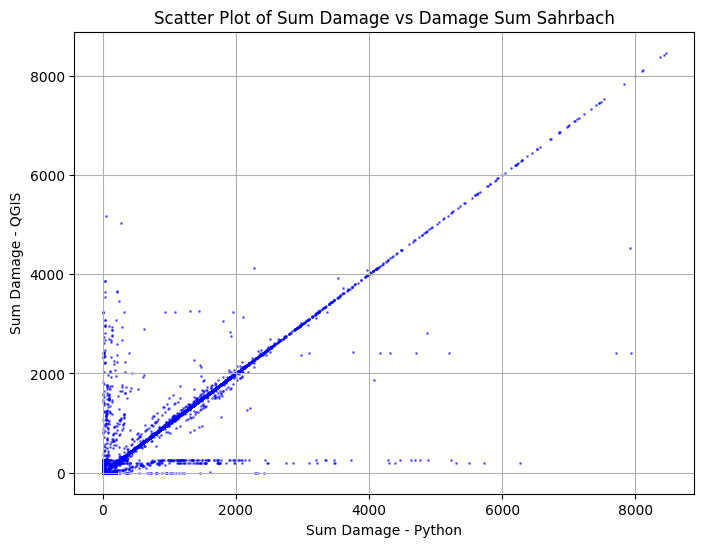

In [53]:
# Paths to the raster files
path_sum_damage = 'Sum_damage.tif'
path_damage_sum_rehbach = r'D:\BEAM\Sahrbach\Sahrbach_damage_sum_omar_model_2.tif'

# Read raster data
with rio.open(path_sum_damage) as src_sum_damage:
    sum_damage = src_sum_damage.read(1)  # Read the first band

with rio.open(path_damage_sum_rehbach) as src_damage_sum_rehbach:
    damage_sum_rehbach = src_damage_sum_rehbach.read(1)  # Read the first band

# Flatten the raster data to 1D arrays
flat_sum_damage = sum_damage.flatten()
flat_damage_sum_rehbach = damage_sum_rehbach.flatten()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(flat_sum_damage, flat_damage_sum_rehbach, s=1, alpha=0.5, color='blue')
plt.xlabel('Sum Damage - Python')
plt.ylabel('Sum Damage - QGIS')
plt.title('Scatter Plot of Sum Damage vs Damage Sum Sahrbach')
plt.grid(True)
plt.show()


In [ ]:
Rehbach Elapsed time: 147.3261649608612 seconds

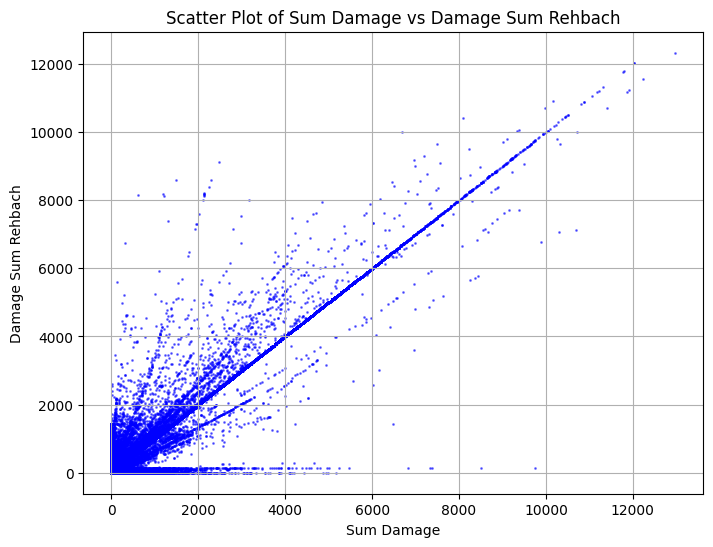

In [52]:
import rasterio
import matplotlib.pyplot as plt

# Paths to the raster files
path_sum_damage = 'Sum_damage.tif'
path_damage_sum_rehbach = r'G:\Abteilung 7\71_2 Hochwasserschutz\Aktenverzeichnis\712-16.04 EG-HWRM-RL\1 PFRA\3. Zyklus\QGIS-Modell Schadenspotenzial\Ergebnis_Beispiele\Rehbach\damage_sum_rehbach.tif'

# Read raster data
with rasterio.open(path_sum_damage) as src_sum_damage:
    sum_damage = src_sum_damage.read(1)  # Read the first band

with rasterio.open(path_damage_sum_rehbach) as src_damage_sum_rehbach:
    damage_sum_rehbach = src_damage_sum_rehbach.read(1)  # Read the first band

# Flatten the raster data to 1D arrays
flat_sum_damage = sum_damage.flatten()
flat_damage_sum_rehbach = damage_sum_rehbach.flatten()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(flat_sum_damage, flat_damage_sum_rehbach, s=1, alpha=0.5, color='blue')
plt.xlabel('Sum Damage - Python')
plt.ylabel('Sum Damage - QGIS')
plt.title('Scatter Plot of Sum Damage vs Damage Sum Rehbach')
plt.grid(True)
plt.show()
